In [71]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import os
import warnings
warnings.filterwarnings("ignore")
import datetime
from shapely.geometry import Point
# from tqdm import tqdm
import time
# import matplotlib.pyplot as plt
from shapely.geometry.point import Point
import geopandas as gpd

In [72]:
# reading shapefile of uttarakhand districts
shape_file_path = r"C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India_Districts_map_JK_LD.geojson"
poly_file = gpd.read_file(shape_file_path)
shape_uttarakhand = poly_file["geometry"]
# shape_uttarakhand
# poly_file

In [3]:
# path = r'C:\Users\Admin\Desktop\Desktop\GeoJSON files\India\Indian_States.shp'

In [73]:
import geopandas as gpd
import pandas as pd

def stamp_states(data: pd.DataFrame, shapefile_path: str) -> pd.DataFrame:
    """
    Assigns a state to each record based on its geographical coordinates.

    Parameters:
    - data: pd.DataFrame containing the data with columns 'latitude' and 'longitude'
    - shapefile_path: str, path to the shapefile of India states

    Returns:
    - pd.DataFrame with an added column 'state' indicating the state for each record
    """
    # Load the India states shapefile
    india_states_gdf = gpd.read_file(shapefile_path)
    
    # Convert the dataframe to a GeoDataFrame
    data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
    
    # Ensure the CRS matches
    data_gdf.set_crs(epsg=4326, inplace=True)
    india_states_gdf = india_states_gdf.to_crs(epsg=4326)
    
    # Perform spatial join to find the state for each record
    data_with_states = gpd.sjoin(data_gdf, india_states_gdf, how='left', predicate='within')
    
    # Select relevant columns
    stamped_data = data_with_states[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'st_nm','Nearest airport',
       'Coordinates of airport', 'Distance to airport (km)', 'Action chosen', 'keep']]
    stamped_data=stamped_data.rename(columns={'st_nm':'state'})
    return stamped_data

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def fill_missing_states(df, target_column='state', feature_columns=['latitude', 'longitude'], n_neighbors=1):
    """
    Fill missing values in the DataFrame using KNN based on specified feature columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_column (str): The name of the column with missing values to fill.
    feature_columns (list): List of feature column names to use for KNN.
    n_neighbors (int): Number of neighbors to use for KNN.

    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    # Convert 'datetime' column to datetime type if present
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Separate rows with and without NaN in target column
    df_complete = df.dropna(subset=[target_column])
    df_missing = df[df[target_column].isna()]

    # Prepare training data for KNN
    X_train = df_complete[feature_columns]
    y_train = df_complete[target_column]

    # Initialize KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit KNN model
    knn.fit(X_train, y_train)

    # Prepare data for prediction (only rows with missing values)
    X_missing = df_missing[feature_columns]

    # Predict missing values
    predicted_values = knn.predict(X_missing)

    # Fill missing values in the original DataFrame
    df.loc[df_missing.index, target_column] = predicted_values

    return df




In [74]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Function to stamp districts against lat_lon_coordinates
def add_districts(df, poly_file):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    coordinates_gdf = gpd.GeoDataFrame(df, geometry=geometry)
    print(f' coordinates_gdf shape: {coordinates_gdf.shape}')
    
    # Perform the spatial join
    joined_gdf = gpd.sjoin(coordinates_gdf, poly_file, how='left', predicate='within')
    print(f' joined_gdf shape: {joined_gdf.shape}')
    
    # Select relevant columns and rename them
    joined_gdf = joined_gdf[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'state', 'name', 'Nearest airport',
       'Coordinates of airport', 'Distance to airport (km)', 'Action chosen', 'keep']]
    joined_gdf.rename(columns={'name': 'district'}, inplace=True)
    
    # Replace NaN values in district_id and district columns
    # joined_gdf.fillna({'district_id': 13, 'district': 'Outside'}, inplace=True)
    # print(f' joined_gdf shape after filling NaN: {joined_gdf.shape}')
    # Group by datetime and ensure only one entry per latitude-longitude pair per datetime
   #  grouped_gdf = joined_gdf.groupby(['maid','datetime', 'latitude', 'longitude']).first().reset_index()
    # Drop duplicates based on maid, datetime, latitude, and longitude, keeping the first occurrence
    grouped_gdf = joined_gdf.drop_duplicates(subset=['maid', 'datetime', 'latitude', 'longitude'], keep='first')
    print(f'grouped_gdf shape after dropping duplicates: {grouped_gdf.shape}')
    
    # Return the final DataFrame
    return grouped_gdf


def fill_missing_districts(df, target_column='district', feature_columns=['latitude', 'longitude'], n_neighbors=1):
    """
    Fill missing values in the DataFrame using KNN based on specified feature columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_column (str): The name of the column with missing values to fill.
    feature_columns (list): List of feature column names to use for KNN.
    n_neighbors (int): Number of neighbors to use for KNN.

    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    # Convert 'datetime' column to datetime type if present
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Separate rows with and without NaN in target column
    df_complete = df.dropna(subset=[target_column])
    df_missing = df[df[target_column].isna()]

    # Prepare training data for KNN
    X_train = df_complete[feature_columns]
    y_train = df_complete[target_column]

    # Initialize KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit KNN model
    knn.fit(X_train, y_train)

    # Prepare data for prediction (only rows with missing values)
    X_missing = df_missing[feature_columns]

    # Predict missing values
    predicted_values = knn.predict(X_missing)

    # Fill missing values in the original DataFrame
    df.loc[df_missing.index, target_column] = predicted_values

    return df


In [75]:
import pandas as pd

def remove_unnecessary_timestamps(df):
    """
    Filters the dataframe to keep only the first and last records where latitude and longitude remain the same
    across consecutive timestamps for each maid.

    Parameters:
    df (pd.DataFrame): Input dataframe containing 'maid', 'datetime', 'latitude', and 'longitude' columns.

    Returns:
    pd.DataFrame: Filtered dataframe with only the first and last records where coordinates remain the same for each maid.
    """
    # Round latitude and longitude to 4 decimal places
    df['latitude'] = df['latitude'].astype(float).round(4)
    df['longitude'] = df['longitude'].astype(float).round(4)
    # Sort by 'maid' and 'datetime' to ensure consecutive timestamps are in order within each maid
    df = df.sort_values(by=['maid', 'datetime','latitude','longitude']).reset_index(drop=True)

    # Identify and keep first and last records where lat and long remain the same within each maid
    df['prev_lat'] = df.groupby('maid')['latitude'].shift(1)
    df['prev_long'] = df.groupby('maid')['longitude'].shift(1)
    df['next_lat'] = df.groupby('maid')['latitude'].shift(-1)
    df['next_long'] = df.groupby('maid')['longitude'].shift(-1)

    # Filter to keep rows where latitude or longitude changes within each maid
    filtered_df = df[(df['latitude'] != df['prev_lat']) |
                     (df['longitude'] != df['prev_long']) |
                     (df['latitude'] != df['next_lat']) |
                     (df['longitude'] != df['next_long'])]
    filtered_df.drop(['prev_lat', 'prev_long', 'next_lat', 'next_long'], axis=1, inplace=True)
    # Drop records for maids with only one record
    # Count occurrences of each maid
    maid_counts = df['maid'].value_counts()
    maid_single_records = maid_counts[maid_counts == 1].index
    filtered_df = filtered_df[~filtered_df['maid'].isin(maid_single_records)]

    return filtered_df



In [84]:
df_with_type_3 = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\stepwise processed records\Type 2\14_filtered_threshold_dist_1000_vel_500_dist_prev_next_700_time_gap_840_min.csv')

In [88]:
df_with_type_3.shape  #(8060125, 12)
df_with_type_3['maid'].nunique() # 132238 df_with_type_3.shape

132238

In [89]:
df_without_type_3 = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\data_with_type_3_airports_vel_fixed_stage_final.csv')

In [90]:
df_without_type_3.shape


(3871854, 13)

In [91]:
ids_had_trouble = df_without_type_3['maid'].unique().tolist()
len(ids_had_trouble) #51013

51013

In [92]:
df_without_any_issue = df_with_type_3[~df_with_type_3['maid'].isin(set(ids_had_trouble))]

In [93]:
df_without_any_issue['maid'].nunique() #81225
df_without_any_issue.shape # (4073447, 12)

(4073447, 12)

In [94]:
df_all = pd.concat([df_without_any_issue, df_without_type_3])
df_all.shape # (7945301, 17)

(7945301, 17)

In [95]:
df_all.columns
df_all = df_all[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'keep', 'Nearest airport',
       'Coordinates of airport', 'Distance to airport (km)', 'Action chosen']]
# 


In [96]:
df_without_type_3.iloc[0]

maid                        000010b7-6bd5-4296-9235-2a824209b773
datetime                              2022-09-03 08:08:03.000000
latitude                                                30.44185
longitude                                               77.61102
displacement                                                 0.0
distance                                                     0.0
Velocity                                                     0.0
keep                                                        True
Nearest airport                                                0
Coordinates of airport                                         0
Distance to airport (km)                                     0.0
Added                                                        0.0
Action chosen                                                NaN
Name: 0, dtype: object

In [97]:
df_all.iloc[4073447]

maid                        000010b7-6bd5-4296-9235-2a824209b773
datetime                              2022-09-03 08:08:03.000000
latitude                                                30.44185
longitude                                               77.61102
displacement                                                 0.0
distance                                                     0.0
Velocity                                                     0.0
keep                                                        True
Nearest airport                                                0
Coordinates of airport                                         0
Distance to airport (km)                                     0.0
Action chosen                                                NaN
Name: 0, dtype: object

In [98]:
df_all['datetime'] = pd.to_datetime(df_all['datetime'], format='mixed', errors='coerce')


In [99]:
# Round latitude and longitude to 4 decimal places
df_all['latitude'] = df_all['latitude'].astype(float).round(4)
df_all['longitude'] = df_all['longitude'].astype(float).round(4)

In [102]:
df_all.drop_duplicates(subset = ['maid', 'datetime', 'latitude', 'longitude'], keep='first', inplace=True)
df_all.shape # (7945301, 12)  after rounding off to 4 digits: 6083460

(3490201, 12)

In [ ]:
import gc
del df_all_1
gc.collect()

In [103]:
df_all = remove_unnecessary_timestamps(df_all)
df_all.shape # (3490201, 12)

(3490201, 12)

In [104]:
df_all.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\df_all_final.csv')

In [105]:
# df_all = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\df_all_final.csv')
df_all.shape

(3490201, 12)

In [113]:

# Convert the DataFrame to a GeoDataFrame
# data['datetime'] = pd.to_datetime(data['datetime'])
data_gdf = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.longitude, df_all.latitude))

# Load the India states shapefile
india_states_gdf = gpd.read_file(shape_file_path)

# Ensure the CRS matches (both are in WGS 84)
data_gdf.set_crs(epsg=4326, inplace=True)
india_states_gdf = india_states_gdf.to_crs(epsg=4326)

# Perform spatial join to find the state for each record
data_with_states = gpd.sjoin(data_gdf, india_states_gdf, how='left', predicate='within')


In [114]:
data_with_states = data_with_states[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'keep', 'Nearest airport', 'Coordinates of airport',
       'Distance to airport (km)', 'Action chosen', 'st_nm','district']]

In [115]:
data_with_states.head()

maid            datetime  latitude  \
0  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:08:03   30.4418   
1  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:08:54   30.4418   
2  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:38:14   30.4368   
3  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:38:23   30.4368   
4  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 11:10:40   31.6866   

   longitude  displacement    distance   Velocity  keep Nearest airport  \
0    77.6110      0.000000    0.000000   0.000000  True               0   
1    77.6110      0.000000    0.000000   0.000000  True               0   
2    77.5827      2.771294    2.771294   5.668556  True               0   
3    77.5827      0.000000    2.771294   0.000000  True               0   
4    76.5218    171.823914  174.596235  67.699036  True          KANGRA   

                     Coordinates of airport  Distance to airport (km)  \
0                                         0                  0.000000   
1                                         0                  0.000000   
2                                         0                  0.000000   
3                                         0                  0.000000   
4  (np.float64(32.165), np.float64(76.263))                 58.534709   

  Action chosen             st_nm  district  
0           NaN  Himachal Pradesh   Sirmaur  
1           NaN  Himachal Pradesh   Sirmaur  
2           NaN  Himachal Pradesh   Sirmaur  
3           NaN  Himachal Pradesh   Sirmaur  
4           NaN  Himachal Pradesh  Hamirpur

In [123]:

# Identify records with multiple state matches
duplicate_states = (data_with_states
                     .groupby(['maid', 'datetime', 'latitude', 'longitude'])
                     .st_nm
                     .nunique()
                     .reset_index()
                     .rename(columns={'st_nm': 'num_states'})
                     .query('num_states > 1'))

# Merge back to get the details of records with multiple state matches
records_with_multiple_states = pd.merge(data_with_states, duplicate_states, 
                                        on=['maid', 'datetime', 'latitude', 'longitude'])
# records_with_multiple_states
# Drop unnecessary columns if needed
records_with_multiple_states = records_with_multiple_states[['maid', 'datetime', 'latitude', 'longitude', 'st_nm', 'district']]

# print("Records with multiple state matches:")
records_with_multiple_states.head(15)
# print(records_with_multiple_states)

maid            datetime  latitude  \
0   055a60bc-8177-42e9-a98b-fa7943b55369 2022-09-09 03:51:22   28.7351   
1   055a60bc-8177-42e9-a98b-fa7943b55369 2022-09-09 03:51:22   28.7351   
2   1024b491-1e0b-448b-b588-41114dc984a0 2022-09-05 14:10:18   28.4487   
3   1024b491-1e0b-448b-b588-41114dc984a0 2022-09-05 14:10:18   28.4487   
4   1024b491-1e0b-448b-b588-41114dc984a0 2022-09-05 14:40:54   28.4487   
5   1024b491-1e0b-448b-b588-41114dc984a0 2022-09-05 14:40:54   28.4487   
6   13e2978b-c03a-475d-83a5-79b8ed68c64a 2022-09-04 05:19:08   28.9784   
7   13e2978b-c03a-475d-83a5-79b8ed68c64a 2022-09-04 05:19:08   28.9784   
8   19325b23-fa4b-436b-9af8-0db5655a194f 2022-09-09 12:41:02   28.8522   
9   19325b23-fa4b-436b-9af8-0db5655a194f 2022-09-09 12:41:02   28.8522   
10  19325b23-fa4b-436b-9af8-0db5655a194f 2022-09-09 12:41:51   28.8522   
11  19325b23-fa4b-436b-9af8-0db5655a194f 2022-09-09 12:41:51   28.8522   
12  199d471f-ded0-4cf8-b0fe-0a15c06daa64 2022-09-14 12:44:20   30.8417   
13  199d471f-ded0-4cf8-b0fe-0a15c06daa64 2022-09-14 12:44:20   30.8417   
14  1dd0b5fa-3182-466b-b0b2-561363c87037 2022-09-14 03:21:56   29.2345   

    longitude             st_nm           district  
0     77.2769             Delhi   North East Delhi  
1     77.2769     Uttar Pradesh          Ghaziabad  
2     77.1222             Delhi        South Delhi  
3     77.1222           Haryana           Gurugram  
4     77.1222             Delhi        South Delhi  
5     77.1222           Haryana           Gurugram  
6     79.3757       Uttarakhand  Udham Singh Nagar  
7     79.3757     Uttar Pradesh             Rampur  
8     77.1702             Delhi        North Delhi  
9     77.1702           Haryana            Sonipat  
10    77.1702             Delhi        North Delhi  
11    77.1702           Haryana            Sonipat  
12    76.9490           Haryana          Panchkula  
13    76.9490  Himachal Pradesh              Solan  
14    78.8476       Uttarakhand  Udham Singh Nagar

In [124]:
data_with_states.shape

(3490312, 14)

In [79]:
df_all= stamp_states(df_all, shape_file_path)
df_all.shape # (3490201, 13)

(3490312, 13)

In [126]:
data_with_states=data_with_states.drop_duplicates(subset=['maid','datetime','latitude','longitude'], keep='first')
data_with_states.shape

(3490201, 14)

In [129]:
data_with_states.rename(columns={'st_nm':'state'}, inplace=True)

In [136]:
x= data_with_states[data_with_states['district'].isna()]
# x.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\records_with_states_NaN_new_shape_file.csv', index=False)

In [143]:
x[['maid','datetime','latitude','longitude','state','district']].head(15)

maid                   datetime  \
24202   01ab56ce-93d5-487a-bb78-43d0fee23053 2022-09-04 16:34:48.000000   
24209   01ab56ce-93d5-487a-bb78-43d0fee23053 2022-09-09 14:30:52.205785   
24212   01ab56ce-93d5-487a-bb78-43d0fee23053 2022-09-12 01:49:57.000000   
24215   01ab56ce-93d5-487a-bb78-43d0fee23053 2022-09-14 01:37:10.000000   
24216   01ab56ce-93d5-487a-bb78-43d0fee23053 2022-09-14 01:37:25.000000   
30968   024172e5-1a3f-4e6c-a198-192de4c54bf8 2022-09-10 13:10:35.000000   
30969   024172e5-1a3f-4e6c-a198-192de4c54bf8 2022-09-10 14:52:13.000000   
30970   024172e5-1a3f-4e6c-a198-192de4c54bf8 2022-09-10 16:07:21.000000   
33704   02754bec-70d0-4a96-9f6a-bfa1b9431067 2022-09-10 03:41:50.000000   
33705   02754bec-70d0-4a96-9f6a-bfa1b9431067 2022-09-10 08:22:26.000000   
100728  0751d908-42aa-4d01-bc2d-356a155a7b8a 2022-09-08 13:10:49.000000   
100729  0751d908-42aa-4d01-bc2d-356a155a7b8a 2022-09-08 15:01:58.000000   
100734  0751d908-42aa-4d01-bc2d-356a155a7b8a 2022-09-10 01:51:18.000000   
100735  0751d908-42aa-4d01-bc2d-356a155a7b8a 2022-09-10 04:18:32.000000   
100739  0751d908-42aa-4d01-bc2d-356a155a7b8a 2022-09-10 12:11:14.000000   

        latitude  longitude state district  
24202    20.4178    72.8373   NaN      NaN  
24209    20.4178    72.8373   NaN      NaN  
24212    20.4178    72.8373   NaN      NaN  
24215    20.4178    72.8373   NaN      NaN  
24216    20.4178    72.8373   NaN      NaN  
30968    29.8011    80.4297   NaN      NaN  
30969    29.8020    80.4300   NaN      NaN  
30970    29.8020    80.4300   NaN      NaN  
33704    21.8811    88.1634   NaN      NaN  
33705    21.8819    88.1628   NaN      NaN  
100728   29.5350    80.3520   NaN      NaN  
100729   29.5350    80.3520   NaN      NaN  
100734   29.5350    80.3521   NaN      NaN  
100735   29.5350    80.3521   NaN      NaN  
100739   29.5349    80.3519   NaN      NaN

In [145]:
import json
# type_counts=[]
with open(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\Resolving type 2\type_2_count_of_rec_at_each_step.json', 'r') as f:
    type_counts = json.load(f)
type_counts

{'0': 39962325,
 '1': 39960238,
 '2': 39945692,
 '3': 39936467,
 '4': 39933663,
 '5': 39932322,
 '6': 39925766,
 '7': 39918914,
 '8': 39914788,
 '9': 39911659,
 '10': 39909329,
 '11': 39907209,
 '12': 39905460,
 '13': 39903508,
 '14': 39901739,
 '15': 39901723,
 '16': 39901723}

In [ ]:
state_counts_with_NaN = df_all['state'].value_counts()
state_counts_with_NaN
# state
# Uttarakhand                 1977952
# Uttar Pradesh                905027
# NCT of Delhi                 294208
# Haryana                       76207
# Rajasthan                     48740
# Punjab                        37553
# Himachal Pradesh              32040
# Maharashtra                   28866
# Gujarat                       16081
# Madhya Pradesh                15230
# Assam                          8587
# Telangana                      8404
# Karnataka                      7682
# Bihar                          6623
# Jammu & Kashmir                4826
# West Bengal                    4803
# Chandigarh                     4682
# Tamil Nadu                     3284
# Andhra Pradesh                 1366
# Odisha                         1366
# Chhattisgarh                   1365
# Jharkhand                      1236
# Sikkim                         1003
# Kerala                          664
# Goa                             625
# Nagaland                        230
# Dadara & Nagar Havelli          172
# Arunanchal Pradesh              133
# Manipur                         100
# Tripura                          98
# Daman & Diu                      98
# Meghalaya                        40
# Mizoram                          32
# Andaman & Nicobar Island          3
# Puducherry                        2
# Name: count, dtype: int64

In [93]:
x= df_all[df_all['state'].isna()]
x['maid'].count()

np.int64(873)

In [94]:
x.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\records_with_states_NaN.csv', index=False)

In [95]:
df_all = fill_missing_states(df_all)
df_all.shape

(3490201, 13)

In [ ]:
state_counts = df_all['state'].value_counts()
state_counts
# state
# Uttarakhand                 1978712
# Uttar Pradesh                905031
# NCT of Delhi                 294208
# Haryana                       76207
# Rajasthan                     48740
# Punjab                        37596
# Himachal Pradesh              32040
# Maharashtra                   28907
# Gujarat                       16090
# Madhya Pradesh                15230
# Assam                          8587
# Telangana                      8404
# Karnataka                      7682
# Bihar                          6625
# Jammu & Kashmir                4826
# West Bengal                    4808
# Chandigarh                     4682
# Tamil Nadu                     3285
# Andhra Pradesh                 1366
# Odisha                         1366
# Chhattisgarh                   1365
# Jharkhand                      1236
# Sikkim                         1003
# Kerala                          668
# Goa                             627
# Nagaland                        230
# Dadara & Nagar Havelli          172
# Arunanchal Pradesh              133
# Daman & Diu                     100
# Manipur                         100
# Tripura                          98
# Meghalaya                        40
# Mizoram                          32
# Andaman & Nicobar Island          3
# Puducherry                        2
# Name: count, dtype: int64

In [109]:
# df_all['district']='Outside'
# df_all_uttarakhand = df_all[df_all['state']=='Uttarakhand'] 
print(f'df_all_uttarakhand shape : {df_all_uttarakhand.shape}') #(1978712, 14)
df_all_uttarakhand = add_districts(df_all_uttarakhand, poly_file=poly_file)
df_all_uttarakhand.shape

df_all_uttarakhand shape : (1978712, 14)
 coordinates_gdf shape: (1978712, 15)
 joined_gdf shape: (1978712, 21)
grouped_gdf shape after dropping duplicates: (1978712, 14)


(1978712, 14)

In [111]:
df_all_uttarakhand['district'].unique()

array(['Dehradun District', 'Pauri Garhwal District', 'Haridwar District',
       'Udham Singh Nagar District', 'Nainital District',
       'Champawat District', 'Tehri Garhwal District', 'Chamoli District',
       'Bageshwar District', 'Pithoragarh District', 'Almora District',
       'Uttarkashi District', nan, 'Rudraprayag District'], dtype=object)

In [112]:
x_uk = df_all_uttarakhand[df_all_uttarakhand['district'].isna()]

In [115]:
x_uk.count() #6482
x_uk['maid'].nunique() # 1101

1101

In [116]:
x_uk.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\Uk_records_with_NaN_districts.csv', index=False)

In [117]:
df_all_uttarakhand= fill_missing_districts(df_all_uttarakhand)
df_all_uttarakhand.shape

(1978712, 14)

In [1]:
df_all_uttarakhand['district'].unique()

NameError: name 'df_all_uttarakhand' is not defined

In [121]:
df_all.shape #(3490201, 14)
df_all.update(df_all_uttarakhand)

In [123]:
df_all[df_all['district']!='Outside'].count()

maid                        1978712
datetime                    1978712
latitude                    1978712
longitude                   1978712
displacement                1978712
distance                    1978712
Velocity                    1978712
state                       1978712
Nearest airport              932155
Coordinates of airport       932155
Distance to airport (km)     932155
Action chosen                 39185
keep                        1978712
district                    1978712
dtype: int64

In [126]:
df_all['state'].unique()

array(['Himachal Pradesh', 'Uttarakhand', 'Uttar Pradesh', 'NCT of Delhi',
       'Chandigarh', 'Maharashtra', 'Punjab', 'Haryana', 'Gujarat',
       'West Bengal', 'Jharkhand', 'Bihar', 'Telangana', 'Karnataka',
       'Rajasthan', 'Jammu & Kashmir', 'Madhya Pradesh', 'Assam',
       'Andhra Pradesh', 'Chhattisgarh', 'Odisha', 'Tamil Nadu',
       'Daman & Diu', 'Kerala', 'Sikkim', 'Nagaland', 'Tripura',
       'Meghalaya', 'Goa', 'Manipur', 'Mizoram', 'Arunanchal Pradesh',
       'Andaman & Nicobar Island', 'Dadara & Nagar Havelli', 'Puducherry'],
      dtype=object)

In [21]:
import pandas as pd

# List of states and union territories with their RTO codes
data = {
    "State/UT": [
        "Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar",
        "Chhattisgarh", "Goa", "Gujarat", "Haryana",
        "Himachal Pradesh", "Jharkhand", "Karnataka", "Kerala",
        "Madhya Pradesh", "Maharashtra", "Manipur", "Meghalaya",
        "Mizoram", "Nagaland", "Odisha", "Punjab",
        "Rajasthan", "Sikkim", "Tamil Nadu", "Telangana",
        "Tripura", "Uttar Pradesh", "Uttarakhand", "West Bengal",
        "Andaman & Nicobar Island", "Chandigarh", "Dadra & Nagar Haveli and Daman & Diu",
        "Lakshadweep", "NCT of Delhi", "Puducherry", "Jammu & Kashmir", "Ladakh"
    ],
    "state_short": [
        "AP", "AR", "AS", "BR",
        "CG", "GA", "GJ", "HR",
        "HP", "JH", "KA", "KL",
        "MP", "MH", "MN", "ML",
        "MZ", "NL", "OD", "PB",
        "RJ", "SK", "TN", "TS",
        "TR", "UP", "UK", "WB",
        "AN", "CH", "DD",
        "LD", "DL", "PY", "JK", "LA"
    ]
}

# Create a DataFrame
df_rto_codes = pd.DataFrame(data)

data = {
    "District Name": [
        "Almora", "Bageshwar", "Chamoli", "Champawat", "Dehradun",
        "Haridwar", "Nainital", "Pauri Garhwal", "Pithoragarh",
        "Rudraprayag", "Tehri Garhwal", "Udham Singh Nagar", "Uttarkashi"
    ],
    "district_short": [
        "ALM", "BGR", "CHM", "CHP", "DDN", "HWR", "NTL", "PRG",
        "PTH", "RUD", "TRG", "USN", "UTS"
    ]
}
df_short_district_names = pd.DataFrame(data)
# Display the DataFrame


In [134]:
df_all['district'] = df_all['district'].str.replace(' District', '')

In [22]:
df_all = pd.merge(df_all, df_rto_codes, how='left', left_on='state', right_on='State/UT')
df_all = pd.merge(df_all, df_short_district_names, how='left', left_on='district', right_on='District Name')


In [30]:
df_all.columns
# df_all= df_all[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
#        'Velocity', 'state','district', 'path', 'state_short', 'district_short',
#          'Nearest airport', 'Coordinates of airport',
#        'Distance to airport (km)', 'Action chosen', 'keep']]
df_all = df_all[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'state', 'district',  'state_short_y',  'district_short_y','path', 'Nearest airport', 'Coordinates of airport',
       'Distance to airport (km)', 'Action chosen', 'keep']]
# df_all.head()

In [35]:
df_all.rename(columns= {'state_short_y': 'state_short', 'district_short_y':'district_short'}, inplace=True)

In [36]:
# trip chainNone
# Add the 'path' column based on state
df_all['path'] = df_all.apply(lambda row: row['district_short'] if row['state'] == 'Uttarakhand' else row['state_short'], axis=1)
x= df_all[df_all['state']=='Uttarakhand']
x.head(15)


maid                    datetime  \
15  000010b7-6bd5-4296-9235-2a824209b773  2022-09-08 12:21:15.000000   
16  000010b7-6bd5-4296-9235-2a824209b773  2022-09-08 14:31:54.000000   
27  000010b7-6bd5-4296-9235-2a824209b773  2022-09-09 15:16:17.000000   
60  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 13:36:15.000000   
61  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 13:36:20.000000   
62  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 13:36:20.000000   
63  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 14:06:05.000000   
64  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 14:06:05.000000   
65  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 14:06:50.000000   
66  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 15:24:37.000000   
67  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 16:33:38.000000   
68  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 16:33:38.000000   
69  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 16:33:48.000000   
70  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 17:50:17.000000   
71  000010b7-6bd5-4296-9235-2a824209b773  2022-09-12 17:50:27.000000   

    latitude  longitude  displacement    distance   Velocity        state  \
15   30.4291    77.7915     18.232966  368.935975   7.768810  Uttarakhand   
16   30.4291    77.7915      0.000959  368.939810   0.001747  Uttarakhand   
27   30.4074    77.7796     17.637468  408.518296  13.097129  Uttarakhand   
60   30.4805    77.8098     12.897032  502.152788  22.483930  Uttarakhand   
61   30.4804    77.8097      0.001339  502.154127   0.963852  Uttarakhand   
62   30.4805    77.8097      0.001235  502.155362        inf  Uttarakhand   
63   30.4804    77.8097      0.000778  502.156140   0.001570  Uttarakhand   
64   30.4805    77.8098      0.000812  502.156952        inf  Uttarakhand   
65   30.4804    77.8097      0.001339  502.158290   0.107095  Uttarakhand   
66   30.4804    77.8097      0.000000  502.158290   0.000000  Uttarakhand   
67   30.4805    77.8097      0.001235  502.159525   0.001073  Uttarakhand   
68   30.4805    77.8098      0.001015  502.160540        inf  Uttarakhand   
69   30.4804    77.8097      0.001468  502.162008   0.528444  Uttarakhand   
70   30.4805    77.8097      0.002216  502.164223   0.001738  Uttarakhand   
71   30.4804    77.8097      0.001468  502.165691   0.528444  Uttarakhand   

    district state_short district_short path Nearest airport  \
15  Dehradun          UK            DDN  DDN               0   
16  Dehradun          UK            DDN  DDN               0   
27  Dehradun          UK            DDN  DDN               0   
60  Dehradun          UK            DDN  DDN               0   
61  Dehradun          UK            DDN  DDN               0   
62  Dehradun          UK            DDN  DDN               0   
63  Dehradun          UK            DDN  DDN               0   
64  Dehradun          UK            DDN  DDN               0   
65  Dehradun          UK            DDN  DDN               0   
66  Dehradun          UK            DDN  DDN               0   
67  Dehradun          UK            DDN  DDN               0   
68  Dehradun          UK            DDN  DDN               0   
69  Dehradun          UK            DDN  DDN               0   
70  Dehradun          UK            DDN  DDN               0   
71  Dehradun          UK            DDN  DDN               0   

   Coordinates of airport  Distance to airport (km) Action chosen  keep  
15                      0                       0.0           NaN  True  
16                      0                       0.0           NaN  True  
27                      0                       0.0           NaN  True  
60                      0                       0.0           NaN  True  
61                      0                       0.0           NaN  True  
62                      0                       0.0           NaN  True  
63                      0                       0.0           NaN  True  
64                      0        

In [37]:
df_all.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\df_all_with_state_district_trip_chain_path.csv', index=False)

In [6]:
df_all =pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\filtering issue from records with in-between timestamps\all_records_without_type!_2-and_3_and_unnecessary_timestamps\df_all_with_state_district_trip_chain_path.csv')

In [7]:
df_all['maid'].count() # 131152 IDs  # 3490201 records

np.int64(3490201)

In [8]:
df_all.columns

Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'state', 'district', 'state_short', 'district_short',
       'path', 'Nearest airport', 'Coordinates of airport',
       'Distance to airport (km)', 'Action chosen', 'keep'],
      dtype='object')

In [51]:
x= df_all[(df_all['Velocity']>=150) & (df_all['displacement']>=50)]
print(f'count: {len(x)}')
Ids = x['maid'].nunique()
print(f'Ids : {Ids}')

count: 59643
Ids : 36705


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Function to plot cumulative distance
def plot_trip_chain(df, prefix=''):
    """
    Plots the cumulative distance against cumulative time for each maid in the dataframe.

    Parameters:
    df (pd.DataFrame): DataFrame containing maid, datetime, distance, and path.
    """

    # Check and convert the datetime column if necessary
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Plotting cumulative distance against cumulative time
    plt.figure(figsize=(18, 6))

    for maid, group in df.groupby('maid'):
        plt.plot(group['datetime'], group['distance'], marker='o', linestyle='-', label=maid)
        
        # Annotate each point with the corresponding path value
        for i, row in group.iterrows():
            plt.annotate(
                row['path'], 
                (row['datetime'], row['distance']),
                textcoords="offset points", 
                xytext=(5, 5),  # Position of text relative to the point
                ha='left', 
                fontsize=6, 
                alpha=0.7,  # Make the text slightly transparent for clarity
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
            )

    plt.xlabel('Date')
    plt.ylabel('Distance (Kms)')

    # Adjusting the legend position and appearance
    plt.legend(
        loc='upper left',
        title='Maid ID',
        fancybox=True,
        framealpha=0.5,
        borderpad=1
    )

    plt.title(f'{prefix}Distance vs Time')

    # Set the x-axis major locator to day and format the dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming df is your DataFrame and it contains columns 'maid', 'datetime', 'distance', and 'path'
# df = pd.DataFrame({
#     'maid': ['A', 'A', 'B', 'B'],
#     'datetime': ['2024-07-31', '2024-08-01', '2024-07-31', '2024-08-01'],
#     'distance': [10, 20, 5, 15],
#     'path': ['Path1', 'Path2', 'Path3', 'Path4']
# })
# df['datetime'] = pd.to_datetime(df['datetime'])
# plot_trip_chain(df)


In [40]:
x_id= df_all.iloc[0]['maid']
x_id

'000010b7-6bd5-4296-9235-2a824209b773'

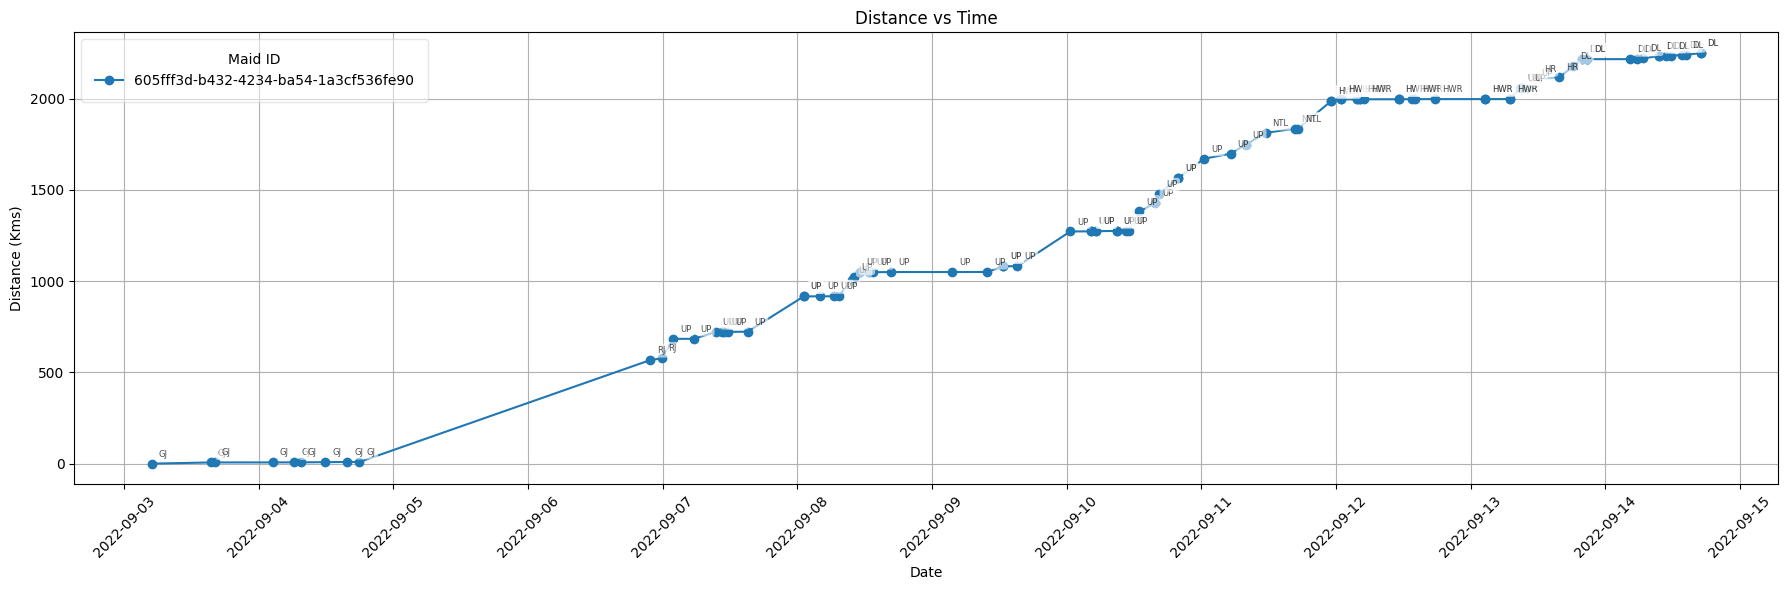

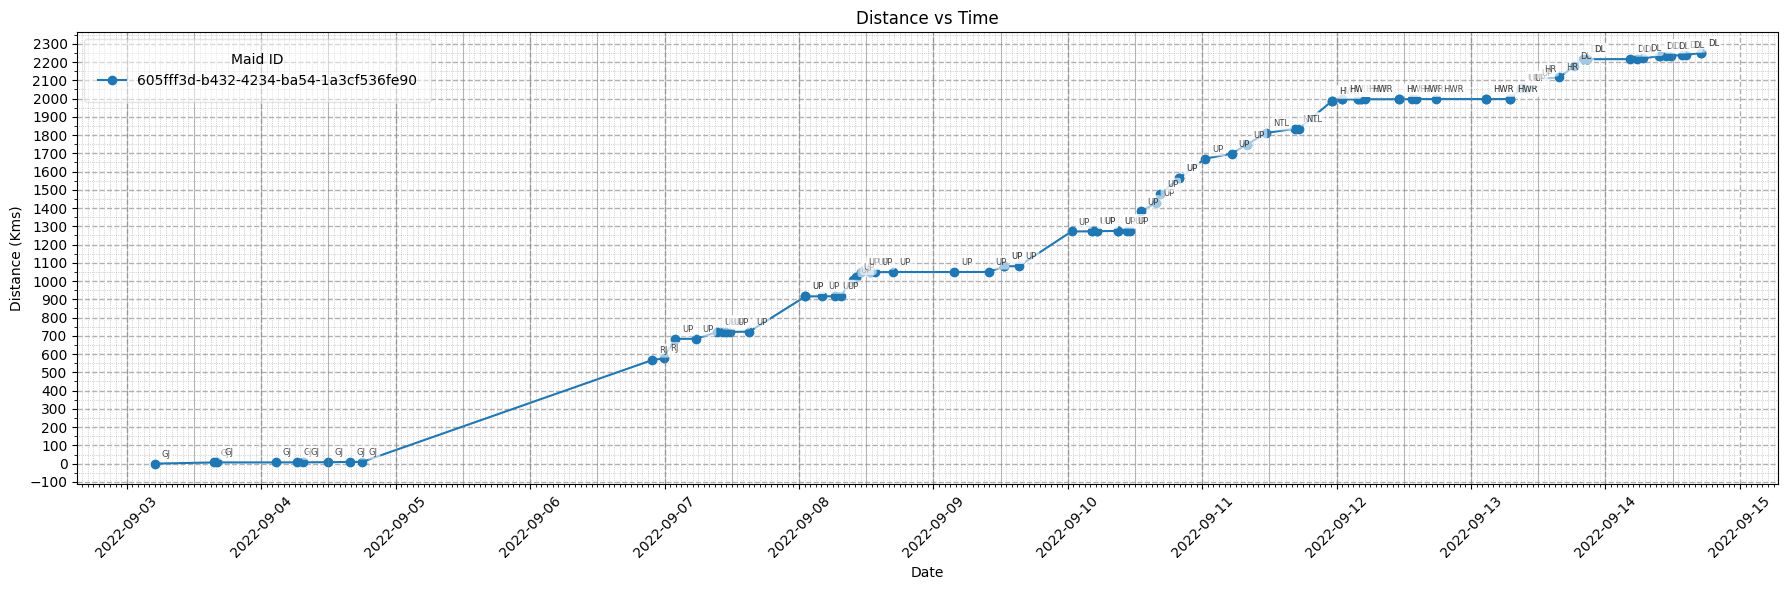

In [33]:
x= df_all[df_all['maid']=='605fff3d-b432-4234-ba54-1a3cf536fe90']
plot_trip_chain(x)
plot_trip_chain_new(x)

In [38]:
df_all.head()

maid                    datetime  latitude  \
0  000010b7-6bd5-4296-9235-2a824209b773  2022-09-03 08:08:03.000000   30.4418   
1  000010b7-6bd5-4296-9235-2a824209b773  2022-09-03 08:08:54.000000   30.4418   
2  000010b7-6bd5-4296-9235-2a824209b773  2022-09-03 08:38:14.000000   30.4368   
3  000010b7-6bd5-4296-9235-2a824209b773  2022-09-03 08:38:23.000000   30.4368   
4  000010b7-6bd5-4296-9235-2a824209b773  2022-09-03 11:10:40.000000   31.6866   

   longitude  displacement    distance   Velocity             state district  \
0    77.6110      0.000000    0.000000   0.000000  Himachal Pradesh  Outside   
1    77.6110      0.000000    0.000000   0.000000  Himachal Pradesh  Outside   
2    77.5827      2.771294    2.771294   5.668556  Himachal Pradesh  Outside   
3    77.5827      0.000000    2.771294   0.000000  Himachal Pradesh  Outside   
4    76.5218    171.823914  174.596235  67.699036  Himachal Pradesh  Outside   

  state_short district_short path Nearest airport  \
0          HP            NaN   HP               0   
1          HP            NaN   HP               0   
2          HP            NaN   HP               0   
3          HP            NaN   HP               0   
4          HP            NaN   HP          KANGRA   

                     Coordinates of airport  Distance to airport (km)  \
0                                         0                  0.000000   
1                                         0                  0.000000   
2                                         0                  0.000000   
3                                         0                  0.000000   
4  (np.float64(32.165), np.float64(76.263))                 58.534709   

  Action chosen  keep  
0           NaN  True  
1           NaN  True  
2           NaN  True  
3           NaN  True  
4           NaN  True

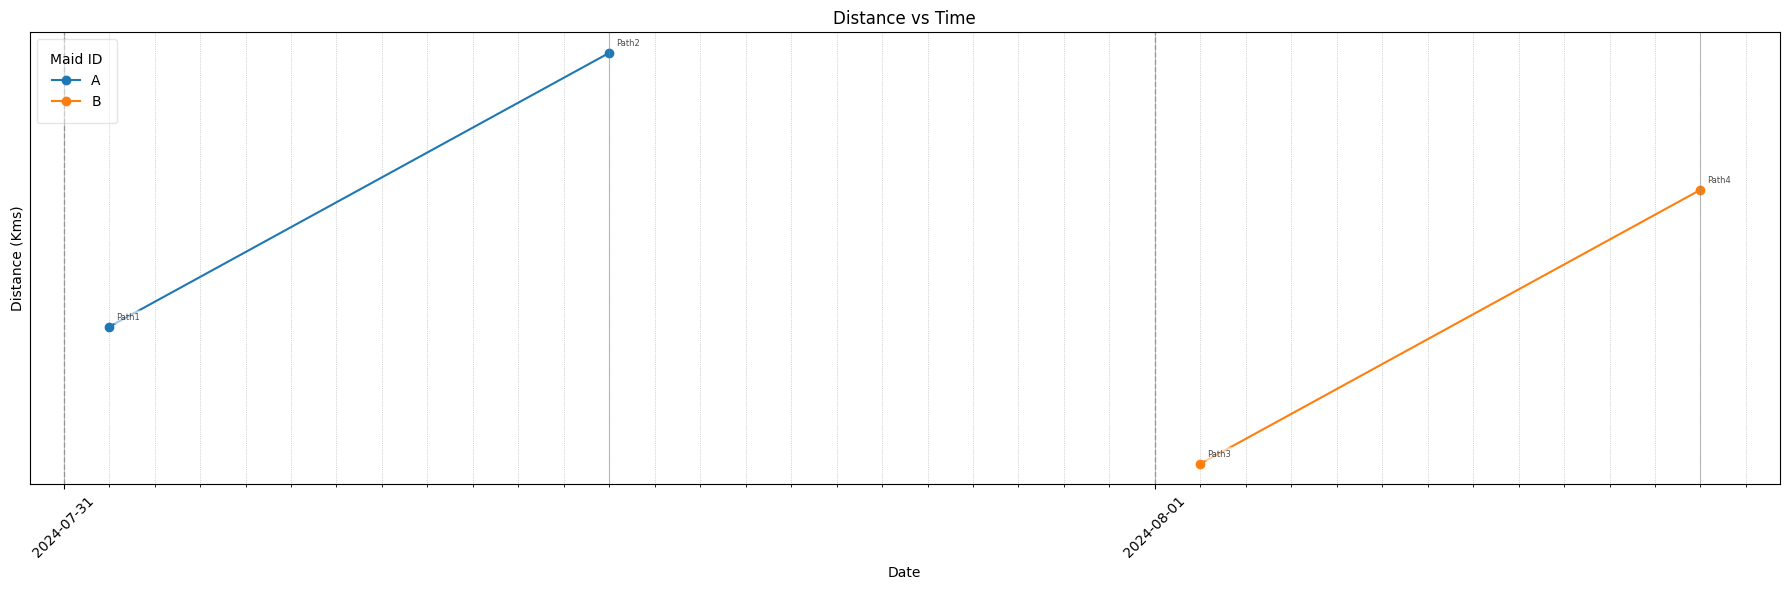

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.ticker as ticker

# Function to plot cumulative distance
def plot_trip_chain_new(df, prefix=''):
    """
    Plots the cumulative distance against cumulative time for each maid in the dataframe.

    Parameters:
    df (pd.DataFrame): DataFrame containing maid, datetime, distance, and path.
    """

    # Check and convert the datetime column if necessary
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Plotting cumulative distance against cumulative time
    plt.figure(figsize=(18, 6))

    for maid, group in df.groupby('maid'):
        plt.plot(group['datetime'], group['distance'], marker='o', linestyle='-', label=maid)
        
        # Annotate each point with the corresponding path value
        for i, row in group.iterrows():
            plt.annotate(
                row['path'], 
                (row['datetime'], row['distance']),
                textcoords="offset points", 
                xytext=(5, 5),  # Position of text relative to the point
                ha='left', 
                fontsize=6, 
                alpha=0.7,  # Make the text slightly transparent for clarity
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
            )

    plt.xlabel('Date')
    plt.ylabel('Distance (Kms)')

    # Adjusting the legend position and appearance
    plt.legend(
        loc='upper left',
        title='Maid ID',
        fancybox=True,
        framealpha=0.5,
        borderpad=1
    )

    plt.title(f'{prefix}Distance vs Time')

    # Set the x-axis major locator to day and format the dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks for each day
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Set minor locator for hourly grid lines
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks for 2 hour

    # Set major ticks on the y-axis every 100 units and minor ticks every 50 units
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))  # Minor ticks for divisions of 50

    plt.xticks(rotation=45)

    # Enable grid for both major and minor ticks
    ax.grid(which='major', linestyle='--', linewidth=1.0)  # Regular grid for major ticks
    ax.grid(which='minor', linestyle=':', linewidth=0.5)   # Regular grid for minor ticks

    # Calculate the start of the day for the first datetime
    first_day_start = df['datetime'].min().normalize()

    # Create a date range with 12-hour frequency starting from first_day_start
    twelve_hour_ticks = pd.date_range(start=first_day_start, end=df['datetime'].max(), freq='12H')

    # Draw thicker lines at each 12-hour interval
    for dt in twelve_hour_ticks:
        ax.axvline(x=dt, linestyle='-', color='gray', linewidth=0.8, alpha=0.5)  # Thicker line for 12-hour grid

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming df is your DataFrame and it contains columns 'maid', 'datetime', 'distance', and 'path'
df = pd.DataFrame({
    'maid': ['A', 'A', 'B', 'B'],
    'datetime': ['2024-07-31 01:00', '2024-07-31 12:00', '2024-08-01 01:00', '2024-08-01 12:00'],
    'distance': [10, 20, 5, 15],
    'path': ['Path1', 'Path2', 'Path3', 'Path4']
})
df['datetime'] = pd.to_datetime(df['datetime'])
plot_trip_chain_new(df)


In [45]:
pd.set_option('display.max_rows', 100)  # Default is 60
pd.set_option('display.max_columns', 20)  # Default is 20
x.head()

maid            datetime  latitude  \
1318569  605fff3d-b432-4234-ba54-1a3cf536fe90 2022-09-03 04:56:58   22.8657   
1318570  605fff3d-b432-4234-ba54-1a3cf536fe90 2022-09-03 15:29:49   22.8107   
1318571  605fff3d-b432-4234-ba54-1a3cf536fe90 2022-09-03 16:10:12   22.8103   
1318572  605fff3d-b432-4234-ba54-1a3cf536fe90 2022-09-04 02:32:31   22.8108   
1318573  605fff3d-b432-4234-ba54-1a3cf536fe90 2022-09-04 06:20:35   22.8131   

         longitude  displacement  distance  Velocity    state district  \
1318569    73.3351      0.000000  0.000000  0.000000  Gujarat  Outside   
1318570    73.3549      6.447728  6.447728  0.611304  Gujarat  Outside   
1318571    73.3540      0.093811  6.541540  0.139381  Gujarat  Outside   
1318572    73.3550      0.106643  6.648183  0.010282  Gujarat  Outside   
1318573    73.3519      0.411231  7.059414  0.108187  Gujarat  Outside   

        state_short district_short path Nearest airport  \
1318569          GJ            NaN   GJ             NaN   
1318570          GJ            NaN   GJ             NaN   
1318571          GJ            NaN   GJ             NaN   
1318572          GJ            NaN   GJ             NaN   
1318573          GJ            NaN   GJ             NaN   

        Coordinates of airport  Distance to airport (km) Action chosen  keep  
1318569                    NaN                       NaN           NaN  True  
1318570                    NaN                       NaN           NaN  True  
1318571                    NaN                       NaN           NaN  True  
1318572                    NaN                       NaN           NaN  True  
1318573                    NaN                       NaN           NaN  True

In [39]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    'maid': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'],
    'datetime': [
        '2024-07-31 01:00', '2024-07-31 12:00', '2024-07-31 18:00', '2024-08-01 01:00',
        '2024-07-31 05:00', '2024-07-31 22:00', '2024-08-01 02:00', '2024-08-01 23:00'
    ],
    'distance': [10, 15, 20, 5, 7, 12, 14, 9],
    'path': ['Path1', 'Path2', 'Path3', 'Path4', 'Path5', 'Path6', 'Path7', 'Path8']
})

# Ensure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Group by 'maid' and date, then count the number of occurrences
count_per_day_per_id = df.groupby(['maid', df['datetime'].dt.date]).size().reset_index(name='count')

# Display the result
print(count_per_day_per_id)


  maid    datetime  count
0    A  2024-07-31      3
1    A  2024-08-01      1
2    B  2024-07-31      2
3    B  2024-08-01      2


In [44]:
df_all['datetime'] = pd.to_datetime(df_all['datetime'])
count_per_day_per_id = df_all.groupby(['maid', df_all['datetime'].dt.date]).size().reset_index(name='count')
count_per_day_per_id = count_per_day_per_id.sort_values(by=['maid','datetime','count'])
count_per_day_per_id.head(25)

maid    datetime  count
0   000010b7-6bd5-4296-9235-2a824209b773  2022-09-03      5
1   000010b7-6bd5-4296-9235-2a824209b773  2022-09-05      4
2   000010b7-6bd5-4296-9235-2a824209b773  2022-09-08      8
3   000010b7-6bd5-4296-9235-2a824209b773  2022-09-09     11
4   000010b7-6bd5-4296-9235-2a824209b773  2022-09-10     10
5   000010b7-6bd5-4296-9235-2a824209b773  2022-09-11      5
6   000010b7-6bd5-4296-9235-2a824209b773  2022-09-12     29
7   000010b7-6bd5-4296-9235-2a824209b773  2022-09-13     11
8   000010b7-6bd5-4296-9235-2a824209b773  2022-09-14     14
9   00004eb1-6900-419c-b4be-0ec37b789989  2022-09-05      1
10  00004eb1-6900-419c-b4be-0ec37b789989  2022-09-06      1
11  00004eb1-6900-419c-b4be-0ec37b789989  2022-09-09      3
12  00004eb1-6900-419c-b4be-0ec37b789989  2022-09-10      1
13  00004eb1-6900-419c-b4be-0ec37b789989  2022-09-11      9
14  00004eb1-6900-419c-b4be-0ec37b789989  2022-09-12      3
15  00004eb1-6900-419c-b4be-0ec37b789989  2022-09-14      2
16  00007182-8140-450f-b91d-b4522543e0f6  2022-09-03      2
17  00007182-8140-450f-b91d-b4522543e0f6  2022-09-05      1
18  00007182-8140-450f-b91d-b4522543e0f6  2022-09-08      2
19  00007182-8140-450f-b91d-b4522543e0f6  2022-09-09      4
20  00007182-8140-450f-b91d-b4522543e0f6  2022-09-10      5
21  00007182-8140-450f-b91d-b4522543e0f6  2022-09-11      1
22  00007182-8140-450f-b91d-b4522543e0f6  2022-09-12     10
23  00007182-8140-450f-b91d-b4522543e0f6  2022-09-13      6
24  00007182-8140-450f-b91d-b4522543e0f6  2022-09-14      9

In [68]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate random data
np.random.seed(42)

# Define date range
date_range = pd.date_range(start='2022-09-03', end='2022-09-14', freq='D')

# Generate random IDs
ids = [f"id_{i:04d}" for i in range(10)]  # 10 random IDs

# Create an empty DataFrame to store the data
data = {
    "maid": [],
    "datetime": [],
    "latitude": [],
    "longitude": [],
}

# Populate the DataFrame with random data
for maid in ids:
    for date in date_range:
        # Random number of entries for each date and ID
        num_records = np.random.randint(1, 5)  # Random count between 1 and 4
        for _ in range(num_records):
            data["maid"].append(maid)
            # Add random time of day to the date
            random_time = timedelta(hours=np.random.randint(0, 24), minutes=np.random.randint(0, 60), seconds=np.random.randint(0, 60))
            data["datetime"].append(date + random_time)
            # Random latitude and longitude
            data["latitude"].append(np.random.uniform(-90, 90))
            data["longitude"].append(np.random.uniform(-180, 180))

# Create DataFrame
df_random = pd.DataFrame(data)

# Convert 'datetime' to pandas datetime type
df_random['datetime'] = pd.to_datetime(df_random['datetime'])
print(df_random)
# Group by 'maid' and 'datetime' (date only), then count records
count_per_day_per_id = df_random.groupby(['maid', df_random['datetime'].dt.date]).size().reset_index(name='count')

# Pivot the table to have dates as columns and IDs as rows
pivot_df = count_per_day_per_id.pivot(index='maid', columns='datetime', values='count').fillna(0)

# Select the date columns for calculation
date_columns = pivot_df.columns

# Add summary statistics for the date columns
pivot_df['Total'] = pivot_df[date_columns].sum(axis=1)
pivot_df['Max'] = pivot_df[date_columns].max(axis=1)
pivot_df['Min'] = pivot_df[date_columns].min(axis=1)
pivot_df['Mean'] = pivot_df[date_columns].mean(axis=1)
pivot_df['Std. Deviation'] = pivot_df[date_columns].std(axis=1)

# Display the resulting DataFrame
# print(pivot_df.head())
pivot_df.head()


        maid            datetime   latitude   longitude
0    id_0000 2022-09-03 19:28:14  41.758910   35.517054
1    id_0000 2022-09-03 06:57:18 -72.004515  -14.670399
2    id_0000 2022-09-03 20:35:39  37.453064 -172.589582
3    id_0000 2022-09-04 23:43:29 -51.778960 -114.543012
4    id_0000 2022-09-04 20:32:11  20.097569 -177.456130
..       ...                 ...        ...         ...
290  id_0009 2022-09-12 12:24:52  32.425339   42.700096
291  id_0009 2022-09-12 05:59:06  68.694684  166.073504
292  id_0009 2022-09-12 18:30:22 -89.073869  115.180890
293  id_0009 2022-09-13 06:30:17  57.234064  119.568304
294  id_0009 2022-09-14 11:38:01 -38.333136   42.093691

[295 rows x 4 columns]


datetime  2022-09-03  2022-09-04  2022-09-05  2022-09-06  2022-09-07  \
maid                                                                   
id_0000            3           2           1           4           4   
id_0001            4           3           3           2           2   
id_0002            4           4           4           4           4   
id_0003            2           1           3           2           3   
id_0004            1           2           1           2           1   

datetime  2022-09-08  2022-09-09  2022-09-10  2022-09-11  2022-09-12  \
maid                                                                   
id_0000            2           4           1           2           1   
id_0001            4           4           4           4           1   
id_0002            3           4           4           1           1   
id_0003            2           4           1           3           4   
id_0004            2           3           1           1           3   

datetime  2022-09-13  2022-09-14  Total  Max  Min      Mean  Std. Deviation  
maid                                                                         
id_0000            1           3     28    4    1  2.333333        1.230915  
id_0001            4           3     38    4    1  3.166667        1.029857  
id_0002            4           1     38    4    1  3.166667        1.337116  
id_0003            4           1     30    4    1  2.500000        1.167748  
id_0004            3           1     21    3    1  1.750000        0.866025

In [69]:
# Group by 'maid' and 'datetime' (date only), then count records
count_per_day_per_id = df_all.groupby(['maid', df_all['datetime'].dt.date]).size().reset_index(name='count')

# Pivot the table to have dates as columns and IDs as rows
pivot_df = count_per_day_per_id.pivot(index='maid', columns='datetime', values='count').fillna(0)

# Select the date columns for calculation
date_columns = pivot_df.columns

# Add summary statistics for the date columns
pivot_df['Total'] = pivot_df[date_columns].sum(axis=1)
pivot_df['Max'] = pivot_df[date_columns].max(axis=1)
pivot_df['Min'] = pivot_df[date_columns].min(axis=1)
pivot_df['Mean'] = pivot_df[date_columns].mean(axis=1)
pivot_df['Std. Deviation'] = pivot_df[date_columns].std(axis=1)
pivot_df.head()


datetime                              2022-09-03  2022-09-04  2022-09-05  \
maid                                                                       
000010b7-6bd5-4296-9235-2a824209b773         5.0         0.0         4.0   
00004eb1-6900-419c-b4be-0ec37b789989         0.0         0.0         1.0   
00007182-8140-450f-b91d-b4522543e0f6         2.0         0.0         1.0   
000188b8-a79f-4d93-8576-47f233b6a937         0.0         0.0         0.0   
0001b7b7-a3f8-4817-b75d-cbef6a98f6bf         0.0         0.0         0.0   

datetime                              2022-09-06  2022-09-07  2022-09-08  \
maid                                                                       
000010b7-6bd5-4296-9235-2a824209b773         0.0         0.0         8.0   
00004eb1-6900-419c-b4be-0ec37b789989         1.0         0.0         0.0   
00007182-8140-450f-b91d-b4522543e0f6         0.0         0.0         2.0   
000188b8-a79f-4d93-8576-47f233b6a937         0.0         0.0         0.0   
0001b7b7-a3f8-4817-b75d-cbef6a98f6bf         0.0         0.0         0.0   

datetime                              2022-09-09  2022-09-10  2022-09-11  \
maid                                                                       
000010b7-6bd5-4296-9235-2a824209b773        11.0        10.0         5.0   
00004eb1-6900-419c-b4be-0ec37b789989         3.0         1.0         9.0   
00007182-8140-450f-b91d-b4522543e0f6         4.0         5.0         1.0   
000188b8-a79f-4d93-8576-47f233b6a937         0.0         0.0         0.0   
0001b7b7-a3f8-4817-b75d-cbef6a98f6bf         0.0         0.0         0.0   

datetime                              2022-09-12  2022-09-13  2022-09-14  \
maid                                                                       
000010b7-6bd5-4296-9235-2a824209b773        29.0        11.0        14.0   
00004eb1-6900-419c-b4be-0ec37b789989         3.0         0.0         2.0   
00007182-8140-450f-b91d-b4522543e0f6        10.0         6.0         9.0   
000188b8-a79f-4d93-8576-47f233b6a937         0.0         0.0         2.0   
0001b7b7-a3f8-4817-b75d-cbef6a98f6bf         1.0         2.0         3.0   

datetime                              Total   Max  Min      Mean  \
maid                                                               
000010b7-6bd5-4296-9235-2a824209b773   97.0  29.0  0.0  8.083333   
00004eb1-6900-419c-b4be-0ec37b789989   20.0   9.0  0.0  1.666667   
00007182-8140-450f-b91d-b4522543e0f6   40.0  10.0  0.0  3.333333   
000188b8-a79f-4d93-8576-47f233b6a937    2.0   2.0  0.0  0.166667   
0001b7b7-a3f8-4817-b75d-cbef6a98f6bf    6.0   3.0  0.0  0.500000   

datetime                              Std. Deviation  
maid                                                  
000010b7-6bd5-4296-9235-2a824209b773        8.117975  
00004eb1-6900-419c-b4be-0ec37b789989        2.570226  
00007182-8140-450f-b91d-b4522543e0f6        3.498918  
000188b8-a79f-4d93-8576-47f233b6a937        0.577350  
0001b7b7-a3f8-4817-b75d-cbef6a98f6bf        1.000000

In [70]:
pivot_df.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\analyzing final records after 3\count_of_time_stamps_per_id_per_day.csv')

In [47]:
# Group by 'maid' and date to count the number of records per day
daily_counts = df_all.groupby(['maid', df_all['datetime'].dt.date]).size().reset_index(name='count')

# Group by 'maid' again to calculate the mean and standard deviation of counts per day
stats_per_maid = daily_counts.groupby('maid')['count'].agg(['mean', 'std']).reset_index()
stats_per_maid = stats_per_maid.sort_values(by=['maid', 'mean', 'std'])
# Display the result
print(stats_per_maid.columns)

Index(['maid', 'mean', 'std'], dtype='object')


In [48]:
stats_per_maid

maid       mean       std
0       000010b7-6bd5-4296-9235-2a824209b773  10.777778  7.612125
1       00004eb1-6900-419c-b4be-0ec37b789989   2.857143  2.853569
2       00007182-8140-450f-b91d-b4522543e0f6   4.444444  3.358240
3       000188b8-a79f-4d93-8576-47f233b6a937   2.000000       NaN
4       0001b7b7-a3f8-4817-b75d-cbef6a98f6bf   2.000000  1.000000
...                                      ...        ...       ...
131147  ffff28a6-b2a5-4ca5-a731-1e6db33d2167   1.500000  0.707107
131148  ffff2b2a-fcf3-4699-8dda-50e05ecfb98d   5.000000  2.966479
131149  ffff3eee-59f6-4aac-a3ec-335266c94525   2.000000       NaN
131150  ffffbfbe-98e6-475c-b062-5ffc589d74aa   1.125000  0.353553
131151  fffffe34-82fd-4ad0-adee-0cf5d29d740d   2.111111  0.927961

[131152 rows x 3 columns]

In [51]:
Ids_with_std_dev_NaN = stats_per_maid[stats_per_maid['std'].isna()]['maid'].unique().tolist()

In [60]:
# df_all[df_all['maid']=='ffff3eee-59f6-4aac-a3ec-335266c94525']
print(len(Ids_with_std_dev_NaN)) #14694
x= df_all[df_all['maid'].isin(set(Ids_with_std_dev_NaN))]

14694


In [61]:
x.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\analyzing final records after 3\records_with_NaN_std_dev.csv', index=False)

In [54]:
# Group by 'maid' and calculate the mean distance per ID
mean_distance_per_id = df_all.groupby('maid')['distance'].mean().reset_index(name='mean_distance')

# Display the result

print(mean_distance_per_id)

                                        maid  mean_distance
0       000010b7-6bd5-4296-9235-2a824209b773     466.923675
1       00004eb1-6900-419c-b4be-0ec37b789989     778.910448
2       00007182-8140-450f-b91d-b4522543e0f6     825.147263
3       000188b8-a79f-4d93-8576-47f233b6a937       0.000000
4       0001b7b7-a3f8-4817-b75d-cbef6a98f6bf      50.649703
...                                      ...            ...
131147  ffff28a6-b2a5-4ca5-a731-1e6db33d2167      97.625456
131148  ffff2b2a-fcf3-4699-8dda-50e05ecfb98d     902.208375
131149  ffff3eee-59f6-4aac-a3ec-335266c94525       0.000000
131150  ffffbfbe-98e6-475c-b062-5ffc589d74aa     486.367508
131151  fffffe34-82fd-4ad0-adee-0cf5d29d740d     500.914700

[131152 rows x 2 columns]


In [63]:
IDs_with_mean_dist_lt_30  = mean_distance_per_id[mean_distance_per_id['mean_distance']<30]['maid'].unique().tolist()
# df_all[df_all['maid']=='ffff3eee-59f6-4aac-a3ec-335266c94525']
print(len(IDs_with_mean_dist_lt_30)) #14694
x= df_all[df_all['maid'].isin(set(IDs_with_mean_dist_lt_30))]
x.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\analyzing final records after 3\records_with_mean_distance_lt_30.csv', index=False)

34481


In [65]:
# Group by 'maid' and calculate the mean distance per ID
total_distance_per_id = df_all.groupby('maid')['distance'].sum().reset_index(name='total_distance')

# Display the result
# print(total_distance_per_id)
IDs_with_total_dist_lt_30  = total_distance_per_id[total_distance_per_id['total_distance']<30]['maid'].unique().tolist()
# df_all[df_all['maid']=='ffff3eee-59f6-4aac-a3ec-335266c94525']
print(len(IDs_with_total_dist_lt_30)) #14694
x= df_all[df_all['maid'].isin(set(IDs_with_total_dist_lt_30))]
x.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\analyzing final records after 3\records_with_total_distance_lt_30.csv', index=False)

25845
